In [ ]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Keras: 2.4.3
OpenCV: 4.1.2
NumPy: 1.19.5
Matplotlib: 3.2.2
Scikit-Image: 0.16.2


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

%matplotlib inline

In [ ]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [ ]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)
prepare_images('source/', 2)

Saving flowers.bmp
Saving head_GT.bmp
Saving man.bmp
Saving face.bmp
Saving ppt3.bmp
Saving comic.bmp
Saving butterfly_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving lenna.bmp
Saving baby_GT.bmp
Saving bridge.bmp
Saving coastguard.bmp
Saving woman_GT.bmp
Saving monarch.bmp
Saving zebra.bmp
Saving baboon.bmp
Saving foreman.bmp
Saving pepper.bmp


In [ ]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


flowers.bmp
PSNR: 24.88592275321631
MSE: 633.2997845303868
SSIM: 0.7894223069949616

head_GT.bmp
PSNR: 29.4934009109717
MSE: 219.2105867346939
SSIM: 0.7397452965417933

man.bmp
PSNR: 25.137155402929974
MSE: 597.7038803100586
SSIM: 0.735684702585557

face.bmp
PSNR: 28.747257347129583
MSE: 260.3010265700483
SSIM: 0.7185510464651969

ppt3.bmp
PSNR: 21.777169198186918
MSE: 1295.6410392364794
SSIM: 0.8746673351446219

comic.bmp
PSNR: 21.16826542909264
MSE: 1490.6479002770084
SSIM: 0.7093499981550738

butterfly_GT.bmp
PSNR: 22.006520728495104
MSE: 1228.9933776855469
SSIM: 0.797964951530857

barbara.bmp
PSNR: 23.447393065729266
MSE: 881.9872540509259
SSIM: 0.73065294994638

bird_GT.bmp
PSNR: 29.79135363470666
MSE: 204.6756847993827
SSIM: 0.9128571831791062

lenna.bmp
PSNR: 29.22505663422242
MSE: 233.18249893188477
SSIM: 0.7874679514772224

baby_GT.bmp
PSNR: 31.69723520103162
MSE: 131.97087478637695
SSIM: 0.8883361032967249

bridge.bmp
PSNR: 23.61629997035871
MSE: 848.3432693481445
SSIM: 0.661

In [ ]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 24.683754875846574
MSE: 663.4773906861002
SSIM: 0.7874282579320199

Reconstructed Image: 
PSNR: 24.719163248368872
MSE: 658.0899988150255
SSIM: 0.7943580012979483



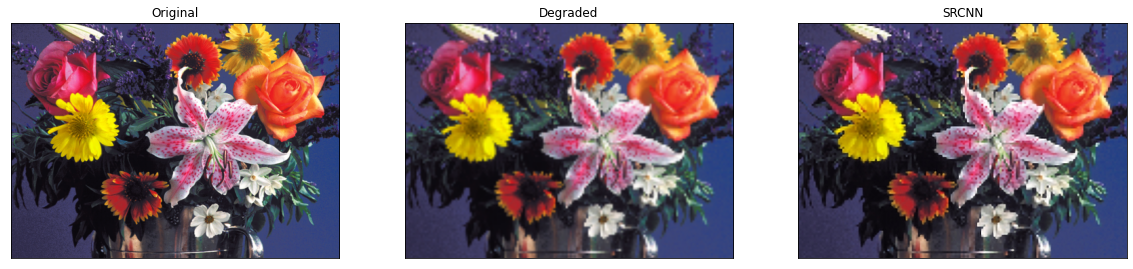

In [ ]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores
ref, degraded, output, scores = predict('images/flowers.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('comparison/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Saving flowers.bmp
Saving head_GT.bmp
Saving man.bmp
Saving face.bmp
Saving ppt3.bmp
Saving comic.bmp
Saving butterfly_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving lenna.bmp
Saving baby_GT.bmp
Saving bridge.bmp
Saving coastguard.bmp
Saving woman_GT.bmp
Saving monarch.bmp
Saving zebra.bmp
Saving baboon.bmp
Saving foreman.bmp
Saving pepper.bmp


In [ ]:
for file in os.listdir('images'):
    input, degraded, output = predict('images/{}'.format(file))
    cv2.imwrite('output/output/{}'.format(file), output)
    cv2.imwrite('output/degraded/{}'.format(file), degraded)
    cv2.imwrite('output/input/{}'.format(file), input)

True

In [ ]:
os.mkdir("downloads") if not os.path.isdir("downloads") else None
!zip -r /content/downloads/referenceImages.zip /content/output/input
!zip -r /content/downloads/lowResolutionImages.zip /content/output/degraded
!zip -r /content/downloads/restoredImages.zip /content/output/output

  adding: content/output/input/ (stored 0%)
  adding: content/output/input/flowers.bmp (deflated 16%)
  adding: content/output/input/head_GT.bmp (deflated 78%)
  adding: content/output/input/man.bmp (deflated 62%)
  adding: content/output/input/face.bmp (deflated 78%)
  adding: content/output/input/ppt3.bmp (deflated 68%)
  adding: content/output/input/comic.bmp (deflated 11%)
  adding: content/output/input/butterfly_GT.bmp (deflated 20%)
  adding: content/output/input/barbara.bmp (deflated 12%)
  adding: content/output/input/bird_GT.bmp (deflated 25%)
  adding: content/output/input/lenna.bmp (deflated 68%)
  adding: content/output/input/baby_GT.bmp (deflated 23%)
  adding: content/output/input/bridge.bmp (deflated 72%)
  adding: content/output/input/coastguard.bmp (deflated 51%)
  adding: content/output/input/woman_GT.bmp (deflated 24%)
  adding: content/output/input/monarch.bmp (deflated 28%)
  adding: content/output/input/zebra.bmp (deflated 12%)
  adding: content/output/input/baboo